# MSE computer
This notebook is completely based on notebook **BEN_step3**. It is just an adapted version of the code that enables us to plot the mean square error comparing the two methods

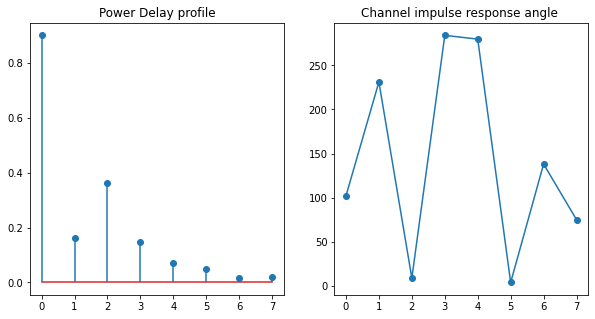

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import erfc, erfcinv

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


mat = scipy.io.loadmat('CIR.mat')
mat['h'].shape
CIR = mat['h']
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.stem(np.abs(CIR))

plt.title("Power Delay profile")

plt.subplot(122)
plt.title("Channel impulse response angle ")
plt.plot(((180/np.pi) * np.angle(CIR))%360, '-o')
plt.show()




def IDFT(OFDM_data):
    return np.sqrt(len(OFDM_data))*np.fft.ifft(OFDM_data)

#Add the CP 
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]  
    return np.hstack([cp, OFDM_time]) 


def awgn(TX, var):
    num=len(TX)
    noisei = np.random.normal(0,np.sqrt(var),num)
    noisej = 1j*np.random.normal(0,np.sqrt(var),num)
    RX = TX[:]+noisei[:]+noisej[:]
    return RX
def conv_channel(TX, impresp):
    return np.convolve(TX,impresp)
    
def removeCP(signal):
    return signal[CP:(CP+K)]

#DFT according to idft
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)/ np.sqrt(len(OFDM_RX))

def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1J / N )
    W = np.power( omega, i * j )# / sqrt(N)
    return W
def chann(IN, esno):
    ESNOdb = esno
    sigs =  2 #Sigmasquare of signal
    ESNO = 10**(ESNOdb/10)
    var=sigs/(ESNO*2)
    var = var * (144/128)
    bits = IDFT(training)
    bits = addCP(bits)

    bits = conv_channel(bits, CIR[:,0])

    bits = awgn(bits,var)

    bits = removeCP(bits)

    bits = DFT(bits)
    #plt.stem(bits)


    output1 = bits
    Y1 = np.asmatrix(np.reshape(output1, (128,1)))
    return Y1


# MSE using the good method

Text(0.5, 1.0, 'MSE as function of ES/NO')

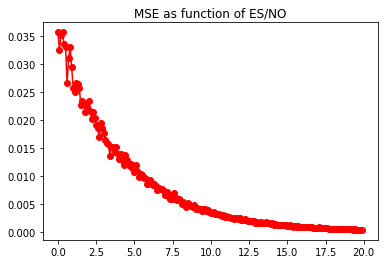

In [17]:
iterations = 50 
#NOTE: specify the number of iterations, as the simulation depends on a gaussian variable,
#we average the result over several cases. 


training = np.tile([1,-1],128//2)
CP=16
K=128
def proutprout(esno):
    training = np.tile([1,-1],128//2)
    CP=16
    K=128
    Y1 = chann(training,esno)
    Y2 = chann(training,esno)
    
    S = np.asmatrix(np.diag(training))
    Mt = S@DFT_matrix(128)



    M=Mt[:,:8]



    H = (M.H@M + M.H@M)
    H = np.linalg.inv(H)

    P = (M.H@Y1 + M.H@Y2)
    H = H@P
    
    estres = np.fft.fft(H, n=128, axis=0)
    realres = np.fft.fft(CIR, n=128, axis=0)
    
    MSE = mse = (np.square(np.abs(estres) - np.abs(realres))).mean(axis=0)
    #print(MSE)
    return(MSE)

A=np.arange(0,20, 0.1)
iterations = 50
results = []
for i in A:
    avg = 0
    for p in range(iterations):
        avg += proutprout(i)
    avg /= iterations
    results.append(avg)
    
plt.plot(A,results, '-ro')
plt.title("MSE as function of ES/NO")

# Zero forcing MSE


Text(0.5, 1.0, 'MSE as function of ES/NO using zero forcing')

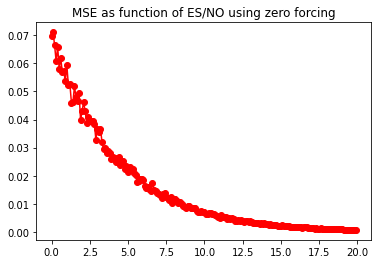

In [18]:
training = np.tile([1,-1],128//2)
CP=16
K=128
def proutprout(esno):
    training = np.tile([1,-1],128//2)
    CP=16
    K=128
    Y1 = chann(training,esno)
    Y2 = chann(training,esno)
    
    S = np.asmatrix(np.diag(training))
    Mt = S@DFT_matrix(128)


    S = np.asmatrix(np.diag(training))
    Mt = S@DFT_matrix(128)



    M=Mt[:,:8]
    Zerof = (np.linalg.pinv(M)@Y1)
    freqres = np.fft.fft(Zerof,n=128, axis=0)

    
    realres = np.fft.fft(CIR, n=128, axis=0)
    
    MSE = mse = (np.square(np.abs(freqres) - np.abs(realres))).mean(axis=0)
    #print(MSE)
    return(MSE)

B=np.arange(0,20, 0.1)
resultsB = []
for i in B:
    avg = 0
    for p in range(iterations):
        avg += proutprout(i)
    avg /= iterations
    resultsB.append(avg)
    
plt.plot(B,resultsB, '-ro')
plt.title("MSE as function of ES/NO using zero forcing")

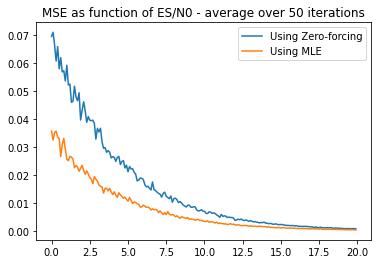

In [21]:
plt.plot(B,resultsB)
plt.plot(A,results)
plt.legend(["Using Zero-forcing", "Using MLE"])
plt.title("MSE as function of ES/N0 - average over {:.0f} iterations".format(iterations))
plt.savefig("Images_channel/50iter.png")